In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import progressbar
from schrodinger_solver import solver
%matplotlib inline

In [2]:
L = 64

In [3]:
def reducing(_in):
    """
       A reducing convolutional layer has 64 filters of size 3x3.
       We use stride 2 to half the data size.
       We use ReLU activation
    """
    return tf.contrib.layers.conv2d(_in, 64, kernel_size=3, stride=2, activation_fn=tf.nn.relu)

def nonreducing(_in):
    """
       A nonreducing convolutional layer has 16 filters of size 4x4.
       We use stride 1 to preserve the data size.
       We use ReLU activation.
    """
    return tf.contrib.layers.conv2d(_in, 16, kernel_size=4, stride=1, activation_fn=tf.nn.relu)
    
def CNN(_in):
    net = tf.reshape(_in, (-1, L, L, 1))
    #If you're using 256x256 potentials, you'll want 6 modules.
    #We'll use 4 since we're using 64x64 potentials
    #  e.g. for 256x256 use   for moduleID in range(6):
    for moduleID in range(4):
        net = nonreducing(nonreducing(reducing(net)))
    net = tf.reshape(net, (-1, 4*4*16))
    net = tf.contrib.layers.fully_connected(net, 1024, activation_fn=tf.nn.relu)
    net = tf.contrib.layers.fully_connected(net, 1, activation_fn=None)
    return net

In [4]:
#data comes in a [ batch * L * L * 1 ] tensor, and labels a [ batch * 1] tensor
x = tf.placeholder(tf.float32, (None, L, L, 1), name='input_image')
y = tf.placeholder(tf.float32, (None, 1))

predicted = CNN(x)
#define the loss function
loss = tf.reduce_mean(tf.square(y-predicted))
#create an optimizer, a training op, and an init op
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [5]:
sess = tf.InteractiveSession()
sess.run(init) 

In [6]:
S = solver(limit=20, L=L, number=50000)
data, labels = S.generate_file()
train_data = data[:40000]
test_data = data[40000:]
train_labels = labels[:40000]
test_labels = labels[40000:]

In [7]:
BATCH_SIZE = 1000
EPOCHS = 100

with progressbar.ProgressBar(max_value=EPOCHS,
                             widgets=[progressbar.Percentage(),
                                      progressbar.Bar(),
                                      progressbar.DynamicMessage('loss'),'|',
                                      progressbar.ETA()], 
                             redirect_stdout=False).start() as bar:
    for epoch in range(EPOCHS):        
        for batch in xrange(train_data.shape[0] / BATCH_SIZE):
            _, loss_val = sess.run([train_step, loss],
                       feed_dict={
                            x: train_data[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE],
                            y: train_labels[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
                        }
                      )
            
            bar.update(epoch, loss=float(loss_val))
            
saver = tf.train.Saver()
saver.save(sess, save_path='./chkpts/')

100%|#############################################|loss: 1.12e-06|Time: 0:10:06


'./chkpts/'

In [8]:
BATCH_SIZE = 1000
bar = progressbar.ProgressBar()
prediction = []
for batch in xrange(test_data.shape[0] / BATCH_SIZE):
    batch_predictions = sess.run(predicted,
                           feed_dict={
                                x: test_data[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE],
                            }
                          )  
    prediction.append(batch_predictions.flatten())
    
prediction = np.array(prediction).flatten()



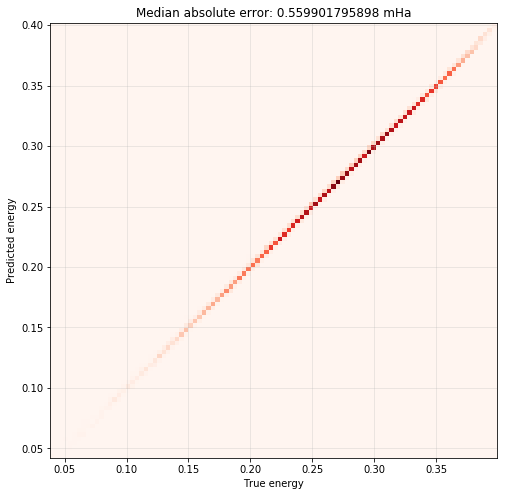

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
counts, xedges, yedges = np.histogram2d(test_labels.flatten(), prediction.flatten(), bins=100)

ax.pcolormesh(xedges, yedges, counts.T, cmap='Reds')

ax.set_xlabel("True energy")
ax.set_ylabel("Predicted energy")
ax.grid(alpha=0.3)
ax.set_title("Median absolute error: {0} mHa".format(np.median(np.abs(prediction.flatten() - test_labels.flatten()))*1000.))
fig.show()